In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from scipy.stats import normaltest
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import missingno as msno

import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import random
seed_value = 99
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

sns.set_theme(style="darkgrid", context= "paper")

In [2]:
HMDA_clean_final = pd.read_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/HMDA_clean_final.pkl")

In [3]:
HMDA_clean_final['loan_granted'] = (HMDA_clean_final['loan_granted'] == 'Granted').astype(int)

HMDA_encoded = pd.get_dummies(HMDA_clean_final, columns=['applicant_sex', 'applicant_race-1', 'loan_type', 'debt_to_income_ratio', 'lien_status'], drop_first=True)

X = HMDA_encoded.drop(columns=['loan_granted'])
y = HMDA_encoded['loan_granted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [4]:
print(X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(545238, 18) (136310, 18) (170388, 18)
(545238,) (136310,) (170388,)


In [5]:
y_train.dtype

dtype('int32')

In [6]:
X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_train_df.head()

county_code  interest_rate  loan_to_value_ratio  applicant_sex_Female  \
0    -1.448136       0.355598             1.551546             -0.729559   
1     0.443058      -0.000074            -0.000527             -0.729559   
2     0.439507      -0.000074            -0.000527             -0.729559   
3     0.439507      -0.000074            -0.000527             -0.729559   
4    -1.437900       2.020717            -1.035981             -0.729559   

   applicant_race-1_White  loan_type_FHA  loan_type_VA  loan_type_FSA/RHS  \
0                0.427279      -0.342862      3.629675          -0.092947   
1               -2.340392      -0.342862     -0.275507          -0.092947   
2                0.427279      -0.342862     -0.275507          -0.092947   
3                0.427279      -0.342862     -0.275507          -0.092947   
4                0.427279      -0.342862     -0.275507          -0.092947   

   debt_to_income_ratio_20%-<30%  debt_to_income_ratio_30%-<36%-41%%  \
0                       -0.36104                           -0.353484   
1                       -0.36104                           -0.353484   
2                       -0.36104                           -0.353484   
3                       -0.36104                           -0.353484   
4                       -0.36104                            2.828979   

   debt_to_income_ratio_36%-41%  debt_to_income_ratio_41%-45%  \
0                     -0.410871                     -0.348057   
1                     -0.410871                     -0.348057   
2                     -0.410871                     -0.348057   
3                     -0.410871                     -0.348057   
4                     -0.410871                     -0.348057   

   debt_to_income_ratio_46%-49%  debt_to_income_ratio_50%-60%  \
0                     -0.303503                      3.836273   
1                      3.294859                     -0.260670   
2                     -0.303503                     -0.260670   
3                     -0.303503                     -0.260670   
4                     -0.303503                     -0.260670   

   debt_to_income_ratio_<20%  debt_to_income_ratio_>60%  \
0                  -0.222307                  -0.206629   
1                  -0.222307                  -0.206629   
2                  -0.222307                  -0.206629   
3                   4.498276                  -0.206629   
4                  -0.222307                  -0.206629   

   debt_to_income_ratio_missing  lien_status_Subordinate lien  
0                     -0.594753                     -0.405707  
1                     -0.594753                     -0.405707  
2                      1.681372                      2.464834  
3                     -0.594753                     -0.405707  
4                     -0.594753                      2.464834

In [7]:
pd.Series(data = [1 if val < 1 else 0 for val in y_train], name = 'S_Train')

0         0
1         1
2         1
3         0
4         0
         ..
545233    1
545234    1
545235    0
545236    0
545237    1
Name: S_Train, Length: 545238, dtype: int64

In [8]:
'''from fairgbm import FairGBMClassifier

core_lgbm_params = {
    "n_estimators": 200,
    "random_state": 69,
    "n_jobs": -2,
}

fairgbm_clf = FairGBMClassifier(
    constraint_type="FNR",    
    multiplier_learning_rate=0.2,
    constraint_fnr_slack=0.05,
    **core_lgbm_params,
)

S_train = pd.Series(data = [1 if val < 1 else 0 for val in y_train], name = 'S_train')

fairgbm_clf.fit(X_train_df, y_train, constraint_group=S_train)'''

'from fairgbm import FairGBMClassifier\n\ncore_lgbm_params = {\n    "n_estimators": 200,\n    "random_state": 69,\n    "n_jobs": -2,\n}\n\nfairgbm_clf = FairGBMClassifier(\n    constraint_type="FNR",    \n    multiplier_learning_rate=0.2,\n    constraint_fnr_slack=0.05,\n    **core_lgbm_params,\n)\n\nS_train = pd.Series(data = [1 if val < 1 else 0 for val in y_train], name = \'S_train\')\n\nfairgbm_clf.fit(X_train_df, y_train, constraint_group=S_train)'

In [9]:
BLD_train_df = pd.get_dummies(HMDA_clean_final.loc[X_train.index], columns=['applicant_sex', 'applicant_race-1', 'loan_type', 'debt_to_income_ratio', 'lien_status'], drop_first=False)
BLD_val_df = pd.get_dummies(HMDA_clean_final.loc[X_val.index], columns=['applicant_sex', 'applicant_race-1', 'loan_type', 'debt_to_income_ratio', 'lien_status'], drop_first=False)
BLD_test_df = pd.get_dummies(HMDA_clean_final.loc[X_test.index], columns=['applicant_sex', 'applicant_race-1', 'loan_type', 'debt_to_income_ratio', 'lien_status'], drop_first=False)

In [10]:
for col in BLD_train_df.columns:
    if BLD_train_df[col].dtype == 'bool':
        BLD_train_df[col] = BLD_train_df[col].astype(int)

for col in BLD_val_df.columns:
    if BLD_val_df[col].dtype == 'bool':
        BLD_val_df[col] = BLD_val_df[col].astype(int)

for col in BLD_test_df.columns:
    if BLD_test_df[col].dtype == 'bool':
        BLD_test_df[col] = BLD_test_df[col].astype(int)

In [11]:
BLD_train_df.head()

county_code  interest_rate  loan_to_value_ratio  loan_granted  \
115410       30013       4.990000           100.000000             1   
630420       48119       4.560661            71.241202             0   
612581       48085       4.560661            71.241202             0   
670964       48085       4.560661            71.241202             1   
179727       30111       7.000000            52.055000             1   

        applicant_sex_Male  applicant_sex_Female  \
115410                   1                     0   
630420                   1                     0   
612581                   1                     0   
670964                   1                     0   
179727                   1                     0   

        applicant_race-1_Black or African American  applicant_race-1_White  \
115410                                           0                       1   
630420                                           1                       0   
612581                                           0                       1   
670964                                           0                       1   
179727                                           0                       1   

        loan_type_Conventional  loan_type_FHA  ...  \
115410                       0              0  ...   
630420                       1              0  ...   
612581                       1              0  ...   
670964                       1              0  ...   
179727                       1              0  ...   

        debt_to_income_ratio_30%-<36%-41%%  debt_to_income_ratio_36%-41%  \
115410                                   0                             0   
630420                                   0                             0   
612581                                   0                             0   
670964                                   0                             0   
179727                                   1                             0   

        debt_to_income_ratio_41%-45%  debt_to_income_ratio_46%-49%  \
115410                             0                             0   
630420                             0                             1   
612581                             0                             0   
670964                             0                             0   
179727                             0                             0   

        debt_to_income_ratio_50%-60%  debt_to_income_ratio_<20%  \
115410                             1                          0   
630420                             0                          0   
612581                             0                          0   
670964                             0                          1   
179727                             0                          0   

        debt_to_income_ratio_>60%  debt_to_income_ratio_missing  \
115410                          0                             0   
630420                          0                             0   
612581                          0                             1   
670964                          0                             0   
179727                          0                             0   

        lien_status_First lien  lien_status_Subordinate lien  
115410                       1                             0  
630420                       1                             0  
612581                       0                             1  
670964                       1                             0  
179727                       0                             1  

[5 rows x 24 columns]

In [12]:
BLD_train_df.to_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/BLD_train_df.pkl")
BLD_val_df.to_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/BLD_val_df.pkl")
BLD_test_df.to_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/BLD_test_df.pkl")

In [13]:
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import BinaryLabelDataset

pip install 'aif360[inFairness]'


In [14]:
privileged_groups = [{'applicant_race-1_White': 1}]
unprivileged_groups = [{'applicant_race-1_White': 0}]

privileged_groups_2 = [{'applicant_sex_Male': 1}]
unprivileged_groups_2 = [{'applicant_sex_Male': 0}]

train_bld = BinaryLabelDataset(df=BLD_train_df, label_names=['loan_granted'], protected_attribute_names=['applicant_race-1_White', 'applicant_race-1_Black or African American'], favorable_label=1.0, unfavorable_label=0.0)
train_bld_2 = BinaryLabelDataset(df=BLD_train_df, label_names=['loan_granted'], protected_attribute_names=['applicant_sex_Male', 'applicant_sex_Female'], favorable_label=1.0, unfavorable_label=0.0)


metric_orig_train = BinaryLabelDatasetMetric(train_bld, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

metric_orig_train_2 = BinaryLabelDatasetMetric(train_bld_2, 
                                             unprivileged_groups=unprivileged_groups_2,
                                             privileged_groups=privileged_groups_2)

print("Difference in mean outcomes between unprivileged and privileged groups - Race = %f" % metric_orig_train.mean_difference())
print("Difference in mean outcomes between unprivileged and privileged groups - Sex = %f" % metric_orig_train_2.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups - Race = -0.148808
Difference in mean outcomes between unprivileged and privileged groups - Sex = -0.036731


In [15]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(train_bld)

In [16]:
class_weights_array = dataset_transf_train.instance_weights

In [17]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print(metric_orig_train.disparate_impact())
print(metric_transf_train.disparate_impact())

print("Difference in mean outcomes between unprivileged and privileged groups - Race = %f" % metric_transf_train.mean_difference())

0.7528037780827889
0.9999999999999997
Difference in mean outcomes between unprivileged and privileged groups - Race = -0.000000


In [18]:
print(pd.DataFrame(train_bld.convert_to_dataframe()[0][["county_code", "interest_rate", "loan_to_value_ratio"]]).head(), "\n", "\n", X_train[["county_code", "interest_rate", "loan_to_value_ratio"]].head())

        county_code  interest_rate  loan_to_value_ratio
115410      30013.0       4.990000           100.000000
630420      48119.0       4.560661            71.241202
612581      48085.0       4.560661            71.241202
670964      48085.0       4.560661            71.241202
179727      30111.0       7.000000            52.055000 
 
        county_code  interest_rate  loan_to_value_ratio
115410       30013       4.990000           100.000000
630420       48119       4.560661            71.241202
612581       48085       4.560661            71.241202
670964       48085       4.560661            71.241202
179727       30111       7.000000            52.055000


In [19]:
X_train.astype(float).describe()

county_code  interest_rate  loan_to_value_ratio  \
count  545238.000000  545238.000000        545238.000000   
mean    43877.231382       4.560750            71.250975   
std      9573.854372       1.207122            18.529292   
min     22001.000000       0.000000             0.000000   
25%     48029.000000       4.560661            71.241202   
50%     48201.000000       4.560661            71.241202   
75%     48439.000000       4.740000            78.247750   
max     49057.000000      18.990000           250.000000   

       applicant_sex_Female  applicant_race-1_White  loan_type_FHA  \
count         545238.000000           545238.000000  545238.000000   
mean               0.347368                0.845618       0.105189   
std                0.476134                0.361315       0.306797   
min                0.000000                0.000000       0.000000   
25%                0.000000                1.000000       0.000000   
50%                0.000000                1.000000       0.000000   
75%                1.000000                1.000000       0.000000   
max                1.000000                1.000000       1.000000   

        loan_type_VA  loan_type_FSA/RHS  debt_to_income_ratio_20%-<30%  \
count  545238.000000      545238.000000                  545238.000000   
mean        0.070549           0.008565                       0.115318   
std         0.256070           0.092151                       0.319406   
min         0.000000           0.000000                       0.000000   
25%         0.000000           0.000000                       0.000000   
50%         0.000000           0.000000                       0.000000   
75%         0.000000           0.000000                       0.000000   
max         1.000000           1.000000                       1.000000   

       debt_to_income_ratio_30%-<36%-41%%  debt_to_income_ratio_36%-41%  \
count                       545238.000000                 545238.000000   
mean                             0.111073                      0.144432   
std                              0.314222                      0.351528   
min                              0.000000                      0.000000   
25%                              0.000000                      0.000000   
50%                              0.000000                      0.000000   
75%                              0.000000                      0.000000   
max                              1.000000                      1.000000   

       debt_to_income_ratio_41%-45%  debt_to_income_ratio_46%-49%  \
count                 545238.000000                 545238.000000   
mean                       0.108054                      0.084345   
std                        0.310449                      0.277905   
min                        0.000000                      0.000000   
25%                        0.000000                      0.000000   
50%                        0.000000                      0.000000   
75%                        0.000000                      0.000000   
max                        1.000000                      1.000000   

       debt_to_income_ratio_50%-60%  debt_to_income_ratio_<20%  \
count                 545238.000000              545238.000000   
mean                       0.063625                   0.047093   
std                        0.244085                   0.211838   
min                        0.000000                   0.000000   
25%                        0.000000                   0.000000   
50%                        0.000000                   0.000000   
75%                        0.000000                   0.000000   
max                        1.000000                   1.000000   

       debt_to_income_ratio_>60%  debt_to_income_ratio_missing  \
count              545238.000000                 545238.000000   
mean                    0.040947                      0.261301   
std                     0.198168                      0.439344   
min          

In [20]:

directory = 'C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/'

os.makedirs(directory, exist_ok=True)

pickle_file = os.path.join(directory, 'subsets_data.pickle')

subsets = {
    'X_train_scaled': X_train_scaled,
    'X_test_scaled': X_test_scaled,
    'X_val_scaled': X_val_scaled,
    'y_train': y_train,
    'y_test': y_test,
    'y_val': y_val
}

with open(pickle_file, 'wb') as f:
    pickle.dump(subsets, f)


In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
early_stopping_rew = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')
model_checkpoint_rew = ModelCheckpoint('best_model_rew.hdf5', save_best_only=True, monitor='val_loss', mode='min')


model = keras.Sequential([
    keras.layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation="sigmoid")
])

model_rew = keras.Sequential([
    keras.layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation="sigmoid")
])


model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=30, batch_size=48, callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
11360/11360 [==============================] - 34s 3ms/step - loss: 0.3454 - accuracy: 0.8758 - val_loss: 0.3012 - val_accuracy: 0.8945
Epoch 2/30
11360/11360 [==============================] - 40s 4ms/step - loss: 0.3049 - accuracy: 0.8922 - val_loss: 0.2981 - val_accuracy: 0.8950
Epoch 3/30
11360/11360 [==============================] - 49s 4ms/step - loss: 0.2983 - accuracy: 0.8953 - val_loss: 0.2858 - val_accuracy: 0.9003
Epoch 4/30
11360/11360 [==============================] - 45s 4ms/step - loss: 0.2938 - accuracy: 0.8971 - val_loss: 0.2834 - val_accuracy: 0.9020
Epoch 5/30
11360/11360 [==============================] - 36s 3ms/step - loss: 0.2921 - accuracy: 0.8977 - val_loss: 0.2836 - val_accuracy: 0.8983
Epoch 6/30
11360/11360 [==============================] - 48s 4ms/step - loss: 0.2905 - accuracy: 0.8983 - val_loss: 0.2791 - val_accuracy: 0.9034
Epoch 7/30
11360/11360 [==============================] - 44s 4ms/step - loss: 0.2901 - accuracy: 0.8985 - val_loss: 0

In [22]:
# show a summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                608       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [23]:
model_rew.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history_rew = model_rew.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=30, batch_size=48, callbacks=[early_stopping_rew, model_checkpoint_rew], sample_weight=class_weights_array)

Epoch 1/30
11360/11360 [==============================] - 34s 3ms/step - loss: 0.3448 - accuracy: 0.8769 - val_loss: 0.3010 - val_accuracy: 0.8951
Epoch 2/30
11360/11360 [==============================] - 36s 3ms/step - loss: 0.3041 - accuracy: 0.8937 - val_loss: 0.2989 - val_accuracy: 0.8937
Epoch 3/30
11360/11360 [==============================] - 27s 2ms/step - loss: 0.2995 - accuracy: 0.8952 - val_loss: 0.2926 - val_accuracy: 0.8978
Epoch 4/30
11360/11360 [==============================] - 25s 2ms/step - loss: 0.2973 - accuracy: 0.8963 - val_loss: 0.2887 - val_accuracy: 0.8996
Epoch 5/30
11360/11360 [==============================] - 27s 2ms/step - loss: 0.2956 - accuracy: 0.8969 - val_loss: 0.2897 - val_accuracy: 0.8976
Epoch 6/30
11360/11360 [==============================] - 25s 2ms/step - loss: 0.2946 - accuracy: 0.8977 - val_loss: 0.2897 - val_accuracy: 0.9000
Epoch 7/30
11360/11360 [==============================] - 28s 2ms/step - loss: 0.2942 - accuracy: 0.8981 - val_loss: 0

5325/5325 - 5s - loss: 0.2795 - accuracy: 0.9035 - 5s/epoch - 929us/step
5325/5325 - 5s - loss: 0.2851 - accuracy: 0.9015 - 5s/epoch - 882us/step

Test accuracy: 0.9035025835037231

Test accuracy reweighted: 0.9014953970909119


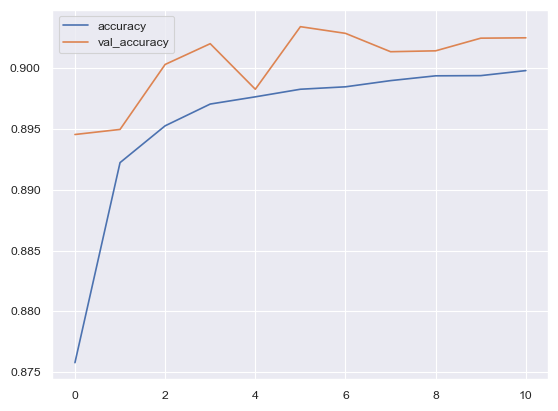

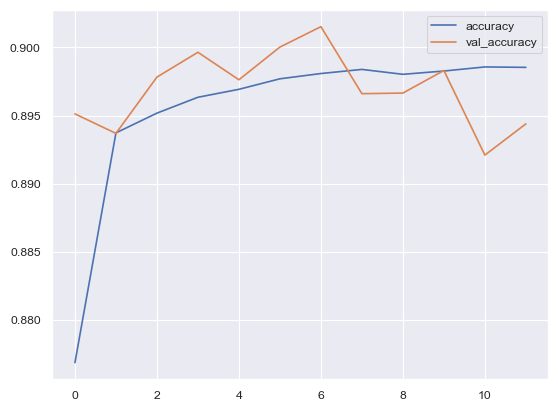

In [24]:
history_df = pd.DataFrame(history.history)
history_df_rew = pd.DataFrame(history_rew.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
history_df_rew.loc[:, ['accuracy', 'val_accuracy']].plot()

test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=2)
test_loss_rew, test_acc_rew = model_rew.evaluate(X_test_scaled, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest accuracy reweighted:', test_acc_rew)

5325/5325 [==============================] - 5s 901us/step
[[58722 12926]
 [ 3516 95224]]
[[58007 13641]
 [ 3143 95597]]
Accuracy: 0.9035025940793953
Precision: 0.8804808136846972
Recall: 0.9643913307676727
F1 Score: 0.920527816714196
Accuracy reweighted: 0.9014954104749161
Precision reweighted: 0.8751258719493217
Recall reweighted: 0.9681689284990885
F1 Score reweighted: 0.9192991566415679
AUC: 0.9434991580888828
AUC reweighted: 0.941961405479927


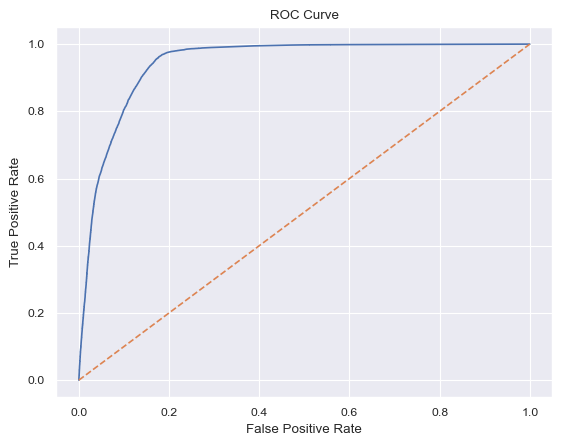

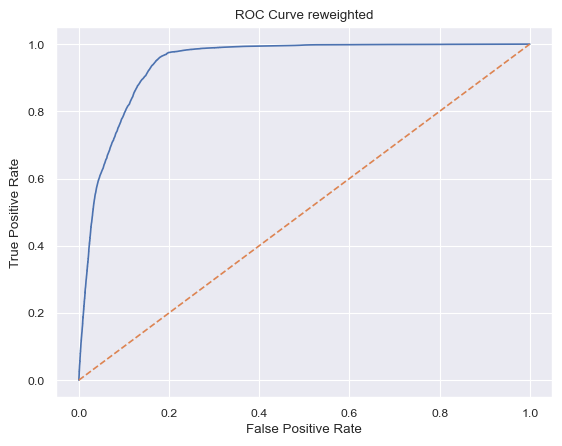

In [25]:
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5)
y_pred_proba = y_pred_proba.ravel()

y_pred_proba_rew = model_rew.predict(X_test_scaled)
y_pred_rew = (y_pred_proba_rew > 0.5)
y_pred_proba_rew = y_pred_proba_rew.ravel()

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

cm_rew = confusion_matrix(y_test, y_pred_rew)
print(cm_rew)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

print("Accuracy reweighted:", accuracy_score(y_test, y_pred_rew))
print("Precision reweighted:", precision_score(y_test, y_pred_rew))
print("Recall reweighted:", recall_score(y_test, y_pred_rew))
print("F1 Score reweighted:", f1_score(y_test, y_pred_rew))

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

fprr, tprr, thresholdsr = roc_curve(y_test, y_pred_proba_rew)

from sklearn.metrics import roc_auc_score
print("AUC:", roc_auc_score(y_test, y_pred_proba))

print("AUC reweighted:", roc_auc_score(y_test, y_pred_proba_rew))

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

plt.plot(fprr, tprr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve reweighted')
plt.show()

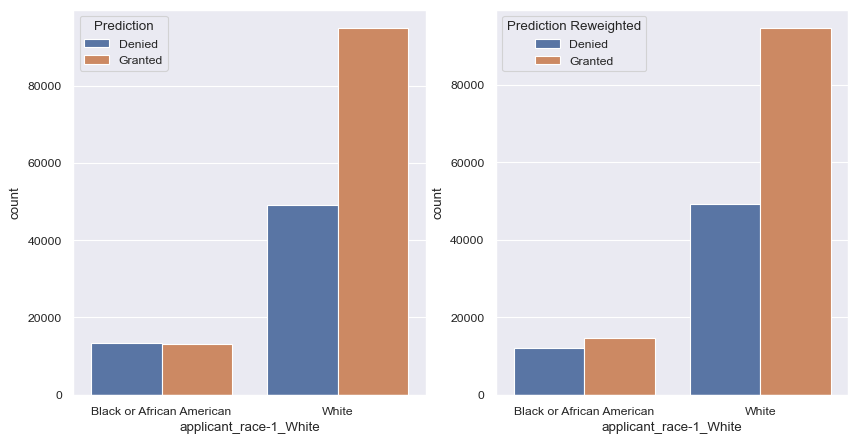

In [26]:
prediction_df = X_test.copy()
prediction_df['prediction'] = y_pred
prediction_df['prediction_proba'] = y_pred_proba
prediction_df['prediction_rew'] = y_pred_rew
prediction_df['prediction_proba_rew'] = y_pred_proba_rew

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=prediction_df, x = "applicant_race-1_White", hue = "prediction")
plt.legend(title = "Prediction", labels = ["Denied", "Granted"])
plt.xticks(ticks=[0, 1], labels=["Black or African American", "White"])
plt.subplot(1, 2, 2)
sns.countplot(data=prediction_df, x = "applicant_race-1_White", hue = "prediction_rew")
plt.legend(title = "Prediction Reweighted", labels = ["Denied", "Granted"])
plt.xticks(ticks=[0, 1], labels=["Black or African American", "White"])
plt.show()

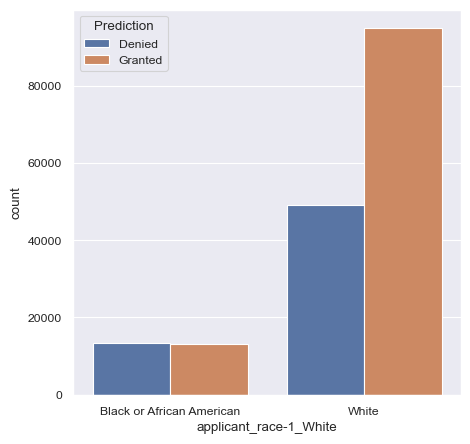

In [27]:
plt.figure(figsize=(5, 5))
sns.countplot(data=prediction_df, x = "applicant_race-1_White", hue = "prediction")
plt.legend(title = "Prediction", labels = ["Denied", "Granted"])
plt.xticks(ticks=[0, 1], labels=["Black or African American", "White"])
plt.show()

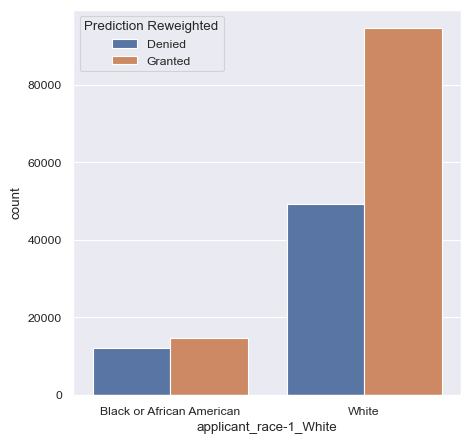

In [28]:
plt.figure(figsize=(5, 5))
sns.countplot(data=prediction_df, x = "applicant_race-1_White", hue = "prediction_rew")
plt.legend(title = "Prediction Reweighted", labels = ["Denied", "Granted"])
plt.xticks(ticks=[0, 1], labels=["Black or African American", "White"])
plt.show()

In [29]:
prediction_df.to_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/prediction_pre_store/prediction_df_orig_rew.pkl")

In [30]:
pred_bld = BinaryLabelDataset(df=prediction_df, label_names=['prediction'], protected_attribute_names=['applicant_race-1_White'], favorable_label=1.0, unfavorable_label=0.0)
pred_bld_rew = BinaryLabelDataset(df=prediction_df, label_names=['prediction_rew'], protected_attribute_names=['applicant_race-1_White'], favorable_label=1.0, unfavorable_label=0.0)

metric_orig_pred = BinaryLabelDatasetMetric(pred_bld, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

metric_orig_pred_rew = BinaryLabelDatasetMetric(pred_bld_rew, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Difference in mean outcomes between unprivileged and privileged groups - Race = %f" % metric_orig_pred.mean_difference())
print("Difference in mean outcomes between unprivileged and privileged groups - Race = %f" % metric_orig_pred_rew.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups - Race = -0.160585
Difference in mean outcomes between unprivileged and privileged groups - Race = -0.110640


In [31]:
X_test

county_code  interest_rate  loan_to_value_ratio  applicant_sex_Female  \
238575       48167       3.625000            96.404000                 False   
328268       49035       4.560661            71.241202                 False   
594872       22019       7.850000            16.000000                 False   
635106       48467       4.560661            71.241202                 False   
451212       22033       0.000000            33.285650                  True   
...            ...            ...                  ...                   ...   
541849       30013       3.700000            65.265000                 False   
472508       48491       6.250000            84.601000                 False   
728610       49035       4.875000            47.009000                 False   
485022       49035       4.500000            60.000000                  True   
843594       30013       4.560661            71.241202                  True   

        applicant_race-1_White  loan_type_FHA  loan_type_VA  \
238575                    True          False         False   
328268                    True          False         False   
594872                    True          False         False   
635106                    True          False         False   
451212                   False          False         False   
...                        ...            ...           ...   
541849                    True          False         False   
472508                    True          False         False   
728610                    True          False         False   
485022                    True          False         False   
843594                    True          False         False   

        loan_type_FSA/RHS  debt_to_income_ratio_20%-<30%  \
238575              False                          False   
328268              False                          False   
594872              False                          False   
635106              False                          False   
451212              False                          False   
...                   ...                            ...   
541849              False                          False   
472508              False                          False   
728610              False                           True   
485022              False                          False   
843594              False                          False   

        debt_to_income_ratio_30%-<36%-41%%  debt_to_income_ratio_36%-41%  \
238575                               False                          True   
328268                               False                         False   
594872                               False                          True   
635106                               False                         False   
451212                               False                         False   
...                                    ...                           ...   
541849                               False                         False   
472508                               False                         False   
728610                               False                         False   
485022                               False                         False   
843594                               False                         False   

        debt_to_income_ratio_41%-45%  debt_to_income_ratio_46%-49%  \
238575                         False                         False   
328268                         False                         False   
594872                         False                         False   
635106                         False                         False   
451212                         False                         False   
...                              ...                           ...   
541849                         False                          True   
472508                          True                         False   
728610                   

In [32]:
mask_white = X_test['applicant_race-1_White'] == 1
mask_black = X_test['applicant_race-1_White'] == 0

y_test_white = y_test[mask_white]
y_test_black = y_test[mask_black]

y_pred_white = y_pred[mask_white]
y_pred_black = y_pred[mask_black]

y_pred_proba_white = y_pred_proba[mask_white]
y_pred_proba_black = y_pred_proba[mask_black]

y_pred_white_rew = y_pred_rew[mask_white]
y_pred_black_rew = y_pred_rew[mask_black]

y_pred_proba_white_rew = y_pred_proba_rew[mask_white]
y_pred_proba_black_rew = y_pred_proba_rew[mask_black]

comp_df_orig_rew = pd.DataFrame({"Original": [accuracy_score(y_test_white, y_pred_white), precision_score(y_test_white, y_pred_white), recall_score(y_test_white, y_pred_white), f1_score(y_test_white, y_pred_white), roc_auc_score(y_test_white, y_pred_proba_white),
                                     accuracy_score(y_test_black, y_pred_black), precision_score(y_test_black, y_pred_black), recall_score(y_test_black, y_pred_black), f1_score(y_test_black, y_pred_black), roc_auc_score(y_test_black, y_pred_proba_black)],
                                     "Reweighted": [accuracy_score(y_test_white, y_pred_white_rew), precision_score(y_test_white, y_pred_white_rew), recall_score(y_test_white, y_pred_white_rew), f1_score(y_test_white, y_pred_white_rew), roc_auc_score(y_test_white, y_pred_proba_white_rew),
                                                    accuracy_score(y_test_black, y_pred_black_rew), precision_score(y_test_black, y_pred_black_rew), recall_score(y_test_black, y_pred_black_rew), f1_score(y_test_black, y_pred_black_rew), roc_auc_score(y_test_black, y_pred_proba_black_rew)]},)

comp_df_orig_rew.index = ["Accuracy White", "Precision White", "Recall White", "F1 Score White", "AUC White", "Accuracy Black", "Precision Black", "Recall Black", "F1 Score Black", "AUC Black"]

comp_df_orig_rew

Original  Reweighted
Accuracy White   0.906750    0.905242
Precision White  0.886117    0.885774
Recall White     0.969923    0.967537
F1 Score White   0.926128    0.924852
AUC White        0.940839    0.940210
Accuracy Black   0.885835    0.881110
Precision Black  0.839948    0.805481
Recall Black     0.924391    0.972741
F1 Score Black   0.880149    0.881245
AUC Black        0.948208    0.948785

In [33]:
comp_df_orig_rew.to_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/result_frames/performance/comp_df_orig_rew.pkl")

In [34]:
results = pd.DataFrame({'label': y_test})
results["score"] = y_pred.astype(int)
results["applicant_sex"] = HMDA_clean_final.loc[results.index, "applicant_sex"]
results["applicant_race-1"] = HMDA_clean_final.loc[results.index, "applicant_race-1"]

results_rew = pd.DataFrame({'label': y_test})
results_rew["score"] = y_pred_rew.astype(int)
results_rew["applicant_sex"] = HMDA_clean_final.loc[results_rew.index, "applicant_sex"]
results_rew["applicant_race-1"] = HMDA_clean_final.loc[results_rew.index, "applicant_race-1"]

results["label"] = results["label"].astype("int")
results["score"] = results["score"].astype("int")

results_rew["label"] = results_rew["label"].astype("int")
results_rew["score"] = results_rew["score"].astype("int")

results["applicant_sex"] = results["applicant_sex"].astype("object")
results["applicant_race-1"] = results["applicant_race-1"].astype("object")

results_rew["applicant_sex"] = results_rew["applicant_sex"].astype("object")
results_rew["applicant_race-1"] = results_rew["applicant_race-1"].astype("object")

In [35]:
print(results.head(), "\n", results.shape, "\n", results.dtypes, "\n", results_rew.head(), "\n", results_rew.shape, "\n", results_rew.dtypes)

        label  score applicant_sex           applicant_race-1
238575      1      1          Male                      White
328268      0      0          Male                      White
594872      1      1          Male                      White
635106      1      1          Male                      White
451212      0      0        Female  Black or African American 
 (170388, 4) 
 label                int32
score                int32
applicant_sex       object
applicant_race-1    object
dtype: object 
         label  score applicant_sex           applicant_race-1
238575      1      1          Male                      White
328268      0      0          Male                      White
594872      1      1          Male                      White
635106      1      1          Male                      White
451212      0      0        Female  Black or African American 
 (170388, 4) 
 label                int32
score                int32
applicant_sex       object
applicant_race-1   

In [36]:
import aequitas

audit = aequitas.Audit(results)
audit_rew = aequitas.Audit(results_rew)

In [37]:
g = aequitas.group.Group()

results_ren = results.copy()
results_ren["label_value"] = results["label"]
results_ren.drop(columns="label", inplace=True)

results_ren_rew = results_rew.copy()
results_ren_rew["label_value"] = results_rew["label"]
results_ren_rew.drop(columns="label", inplace=True)

xtab, _ = g.get_crosstabs(results_ren)
xtab_rew, _ = g.get_crosstabs(results_ren_rew)

In [38]:
absolute_metrics = g.list_absolute_metrics(xtab)
absolute_metrics_rew = g.list_absolute_metrics(xtab_rew)

In [39]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

attribute_name            attribute_value  accuracy   tpr   tnr   for  \
0     applicant_sex                     Female      0.90  0.96  0.83  0.06   
1     applicant_sex                       Male      0.90  0.97  0.81  0.05   
2  applicant_race-1  Black or African American      0.89  0.92  0.85  0.07   
3  applicant_race-1                      White      0.91  0.97  0.81  0.05   

    fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0  0.12  0.17  0.04  0.94       0.88  0.33   0.61  0.56  
1  0.12  0.19  0.03  0.95       0.88  0.67   0.65  0.59  
2  0.16  0.15  0.08  0.93       0.84  0.12   0.50  0.45  
3  0.11  0.19  0.03  0.95       0.89  0.88   0.66  0.60

In [40]:
xtab_rew[['attribute_name', 'attribute_value'] + absolute_metrics_rew].round(2)

attribute_name            attribute_value  accuracy   tpr   tnr   for  \
0     applicant_sex                     Female      0.90  0.97  0.81  0.05   
1     applicant_sex                       Male      0.90  0.97  0.81  0.05   
2  applicant_race-1  Black or African American      0.88  0.97  0.81  0.03   
3  applicant_race-1                      White      0.91  0.97  0.81  0.06   

    fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0  0.13  0.19  0.03  0.95       0.87  0.34   0.62  0.56  
1  0.12  0.19  0.03  0.95       0.88  0.66   0.65  0.59  
2  0.19  0.19  0.03  0.97       0.81  0.13   0.55  0.45  
3  0.11  0.19  0.03  0.94       0.89  0.87   0.66  0.60

In [41]:
aqp = aequitas.plotting.Plot()

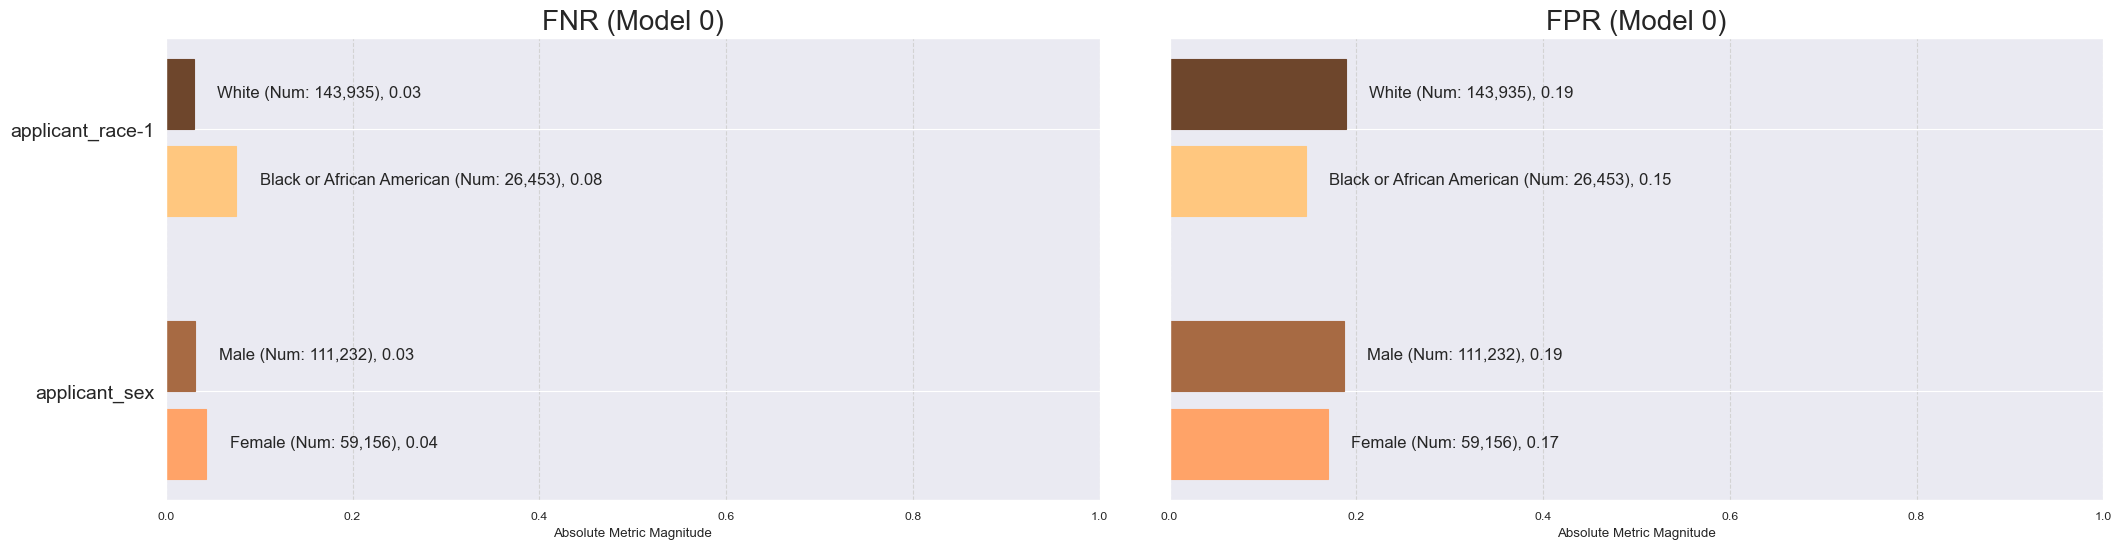

<Figure size 640x480 with 0 Axes>

In [42]:
group_metric_all = aqp.plot_group_metric_all(xtab, metrics=['fnr','fpr'], ncols=2)

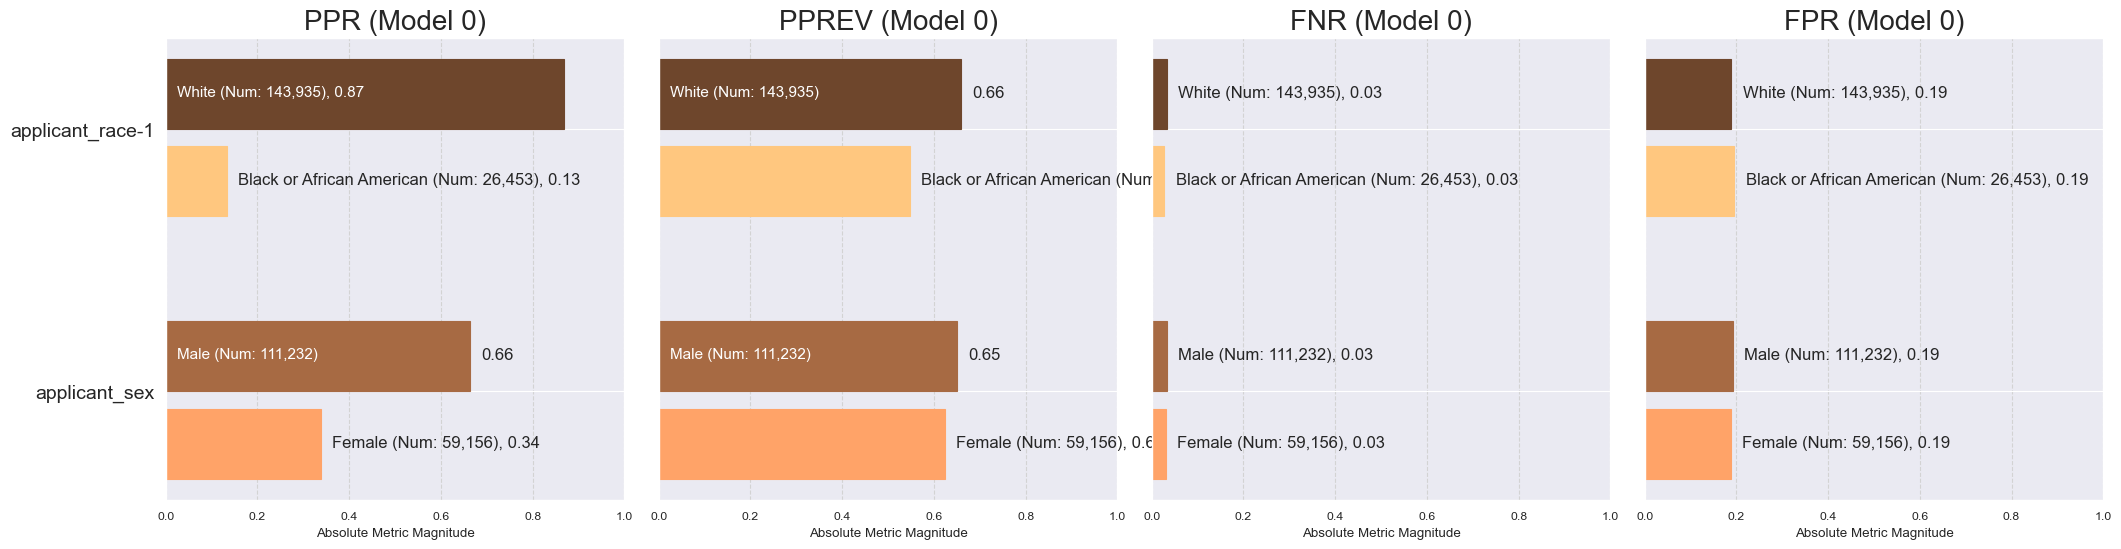

<Figure size 640x480 with 0 Axes>

In [43]:
group_metric_all_rew = aqp.plot_group_metric_all(xtab_rew, metrics=['ppr','pprev','fnr','fpr'], ncols=4)

In [44]:
b = aequitas.bias.Bias()

In [45]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=results_ren, ref_groups_dict={'applicant_race-1':'White', 'applicant_sex':'Male'}, alpha=0.05, mask_significance=True)
bdf.style

In [46]:
bdf_rew = b.get_disparity_predefined_groups(xtab_rew, original_df=results_ren_rew, ref_groups_dict={'applicant_race-1':'White', 'applicant_sex': 'Male'}, alpha=0.05, mask_significance=True)
bdf_rew.style

In [47]:
original_model_results_total = pd.DataFrame({
    'accuracy': [accuracy_score(y_test, y_pred)],
    'precision': [precision_score(y_test, y_pred)],
    'recall': [recall_score(y_test, y_pred)],
    'f1': [f1_score(y_test, y_pred)],
    'roc_auc': [roc_auc_score(y_test, y_pred_proba)],
    'tpr_disparity': [bdf['tpr_disparity'][2]],
    'fpr_disparity': [bdf['fpr_disparity'][2]],
    'tnr_disparity': [bdf['tnr_disparity'][2]],
    'fnr_disparity': [bdf['fnr_disparity'][2]]
})

In [48]:
original_model_results_total

accuracy  precision    recall        f1   roc_auc  tpr_disparity  \
0  0.903503   0.880481  0.964391  0.920528  0.943499       0.953057   

   fpr_disparity  tnr_disparity  fnr_disparity  
0       0.773041       1.052915       2.513832

In [49]:
original_model_results_total_rew = pd.DataFrame({
    'accuracy': [accuracy_score(y_test, y_pred_rew)],
    'precision': [precision_score(y_test, y_pred_rew)],
    'recall': [recall_score(y_test, y_pred_rew)],
    'f1': [f1_score(y_test, y_pred_rew)],
    'roc_auc': [roc_auc_score(y_test, y_pred_proba_rew)],
    'tpr_disparity': [bdf_rew['tpr_disparity'][2]],
    'fpr_disparity': [bdf_rew['fpr_disparity'][2]],
    'tnr_disparity': [bdf_rew['tnr_disparity'][2]],
    'fnr_disparity': [bdf_rew['fnr_disparity'][2]]
})

In [50]:
results_df = pd.concat([original_model_results_total, original_model_results_total_rew], axis=0)
results_df.index = ['Initial_Model', 'Iteration I']
results_df = results_df.T
results_df

Initial_Model  Iteration I
accuracy            0.903503     0.901495
precision           0.880481     0.875126
recall              0.964391     0.968169
f1                  0.920528     0.919299
roc_auc             0.943499     0.941961
tpr_disparity       0.953057     1.005379
fpr_disparity       0.773041     1.030013
tnr_disparity       1.052915     0.992994
fnr_disparity       2.513832     0.839688

In [51]:
results_df.to_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/result_frames/performance/results_df.pkl")

In [52]:
results_df["Initial_Model"][5]

0.9530565536068529

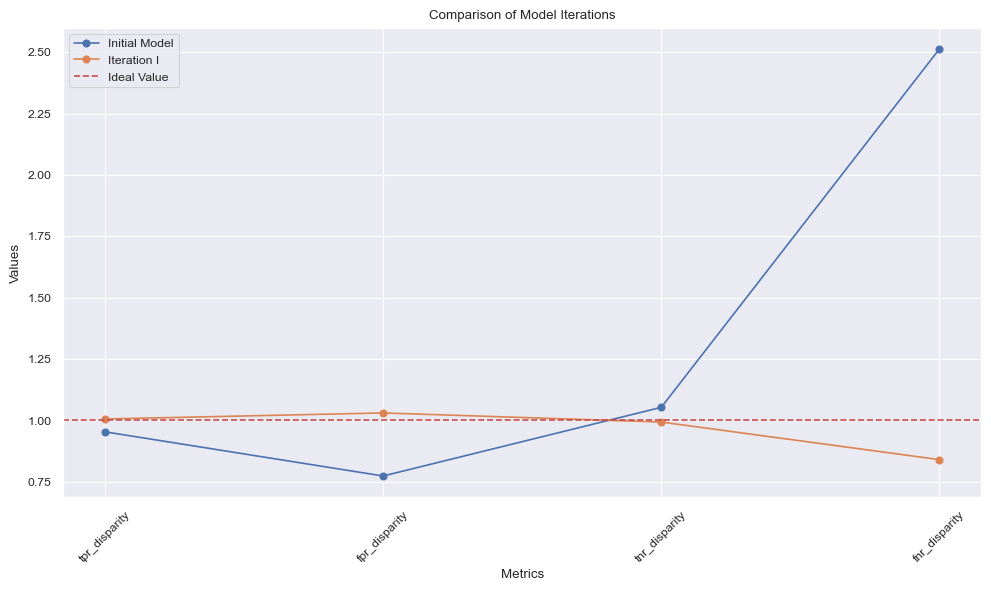

In [53]:
data = {
    'KPI': ['tpr_disparity', 'fpr_disparity', 'tnr_disparity', 'fnr_disparity'],
    'Initial_Model': [results_df["Initial_Model"][5], results_df["Initial_Model"][6], results_df["Initial_Model"][7], results_df["Initial_Model"][8]],
    'Iteration I': [results_df["Iteration I"][5], results_df["Iteration I"][6], results_df["Iteration I"][7], results_df["Iteration I"][8]]
}

df = pd.DataFrame(data)
metrics = df['KPI']
iteration1_values = df['Initial_Model']
iteration2_values = df['Iteration I']

# Plotting
plt.figure(figsize=(10, 6))

# Plot values for Iteration I
plt.plot(metrics, iteration1_values, marker='o', label='Initial Model')

# Plot values for Iteration II
plt.plot(metrics, iteration2_values, marker='o', label='Iteration I')

# Plot reference line at y=1
plt.axhline(y=1, color='r', linestyle='--', label='Ideal Value')

# Set labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of Model Iterations')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
import shap

def f(X):
    return model.predict([X[:, i] for i in range(X.shape[1])]).flatten()

In [55]:
shap.initjs()
explainer = shap.KernelExplainer(model.predict ,shap.sample(X_train_scaled, 100))

4/4 [==============================] - 0s 3ms/step


In [56]:
shap.initjs()
tf.autograph.set_verbosity(0)
shap_values = explainer.shap_values(X_test_scaled[:150], nsamples=150)

  0%|          | 0/150 [00:00<?, ?it/s]

469/469 [==============================] - 1s 1ms/step


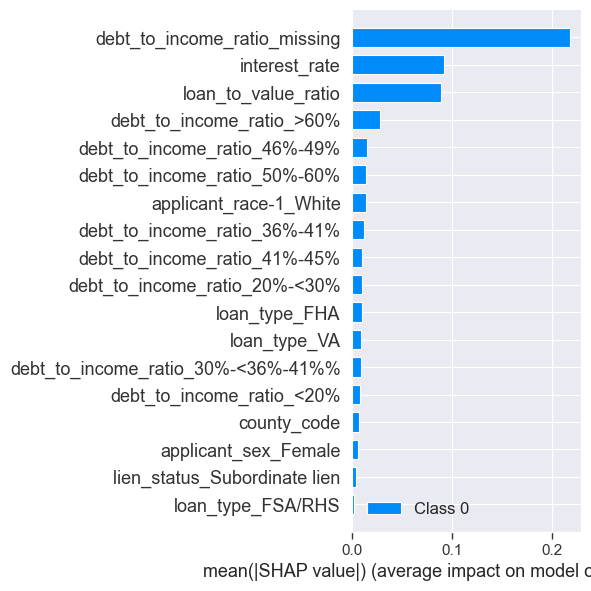

In [57]:
shap.summary_plot(shap_values, X_test_scaled[:150], feature_names=X.columns, plot_size=(6,6))

In [58]:
# pd.DataFrame(sorted(dict(zip(X.columns, shap_values[0][0])).items(), key=lambda x: x[1], reverse=True))

# recreate the dataframe with the mean shap values for X_test[:150]
shap_values_df = pd.DataFrame(shap_values[0], columns=X.columns)
shap_values_df_mean = shap_values_df.abs().mean()
shap_values_df_mean.sort_values(ascending=False, inplace=True)

pd.DataFrame(shap_values_df_mean)

# create a dataframe from shap_values_df_mean where the feature names are a column and the values are a separate column
shap_values_df_mean = shap_values_df_mean.reset_index()
shap_values_df_mean.columns = ['feature', 'shap_value']
shap_values_df_mean

feature  shap_value
0         debt_to_income_ratio_missing    0.218370
1                        interest_rate    0.092245
2                  loan_to_value_ratio    0.088462
3            debt_to_income_ratio_>60%    0.028253
4         debt_to_income_ratio_46%-49%    0.014326
5         debt_to_income_ratio_50%-60%    0.013772
6               applicant_race-1_White    0.013722
7         debt_to_income_ratio_36%-41%    0.011973
8         debt_to_income_ratio_41%-45%    0.010168
9        debt_to_income_ratio_20%-<30%    0.009581
10                       loan_type_FHA    0.009485
11                        loan_type_VA    0.009214
12  debt_to_income_ratio_30%-<36%-41%%    0.008844
13           debt_to_income_ratio_<20%    0.007275
14                         county_code    0.007105
15                applicant_sex_Female    0.006134
16        lien_status_Subordinate lien    0.003911
17                   loan_type_FSA/RHS    0.001997

In [59]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test_scaled[:150], feature_names=X.columns, matplotlib=False)

In [60]:
explainer.expected_value

array([0.56723671])

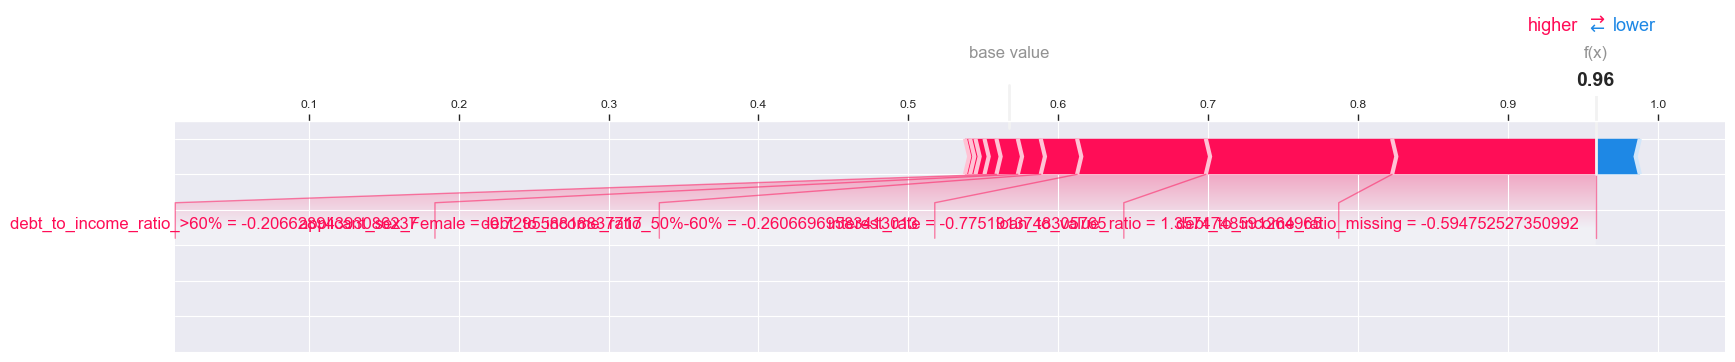

In [61]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0][0], X_test_scaled[0], feature_names=X.columns, matplotlib=True)

In [62]:
for value in range(10):
    print(str(value) + ": Base value", explainer.expected_value, "Shapley value", shap_values[0][value].sum(), "Sum", shap_values[0][value].sum() + explainer.expected_value)

0: Base value [0.56723671] Shapley value 0.39128608296159656 Sum [0.9585228]
1: Base value [0.56723671] Shapley value -0.5607136521255598 Sum [0.00652306]
2: Base value [0.56723671] Shapley value 0.39771027157548816 Sum [0.96494699]
3: Base value [0.56723671] Shapley value 0.1494512636447325 Sum [0.71668798]
4: Base value [0.56723671] Shapley value -0.43755551388021563 Sum [0.1296812]
5: Base value [0.56723671] Shapley value -0.5607595951994881 Sum [0.00647712]
6: Base value [0.56723671] Shapley value 0.3893625814700498 Sum [0.9565993]
7: Base value [0.56723671] Shapley value 0.3802317459369078 Sum [0.94746846]
8: Base value [0.56723671] Shapley value 0.37813163588289167 Sum [0.94536835]
9: Base value [0.56723671] Shapley value 0.13814986536744978 Sum [0.70538658]


In [63]:
y_pred_proba[:10]

array([0.9585228 , 0.00652306, 0.964947  , 0.716688  , 0.12968114,
       0.00647712, 0.9565993 , 0.9474685 , 0.94536835, 0.7053866 ],
      dtype=float32)

In [64]:
pd.DataFrame(sorted(dict(zip(X.columns, shap_values[0][0])).items(), key=lambda x: x[1], reverse=True))

0         1
0         debt_to_income_ratio_missing  0.135822
1                  loan_to_value_ratio  0.124254
2                        interest_rate  0.085906
3         debt_to_income_ratio_50%-60%  0.024242
4                 applicant_sex_Female  0.015297
5            debt_to_income_ratio_>60%  0.014259
6               applicant_race-1_White  0.007967
7         debt_to_income_ratio_41%-45%  0.006025
8            debt_to_income_ratio_<20%  0.003567
9         debt_to_income_ratio_46%-49%  0.003396
10                         county_code  0.000000
11                       loan_type_FHA  0.000000
12                        loan_type_VA  0.000000
13                   loan_type_FSA/RHS  0.000000
14       debt_to_income_ratio_20%-<30%  0.000000
15  debt_to_income_ratio_30%-<36%-41%%  0.000000
16        lien_status_Subordinate lien  0.000000
17        debt_to_income_ratio_36%-41% -0.029450

In [65]:
explainer_rew = shap.KernelExplainer(model_rew.predict ,shap.sample(X_train_scaled, 100))
shap_values_rew = explainer_rew.shap_values(X_test_scaled[:150], nsamples=150)

4/4 [==============================] - 0s 1ms/step


  0%|          | 0/150 [00:00<?, ?it/s]

469/469 [==============================] - 1s 3ms/step


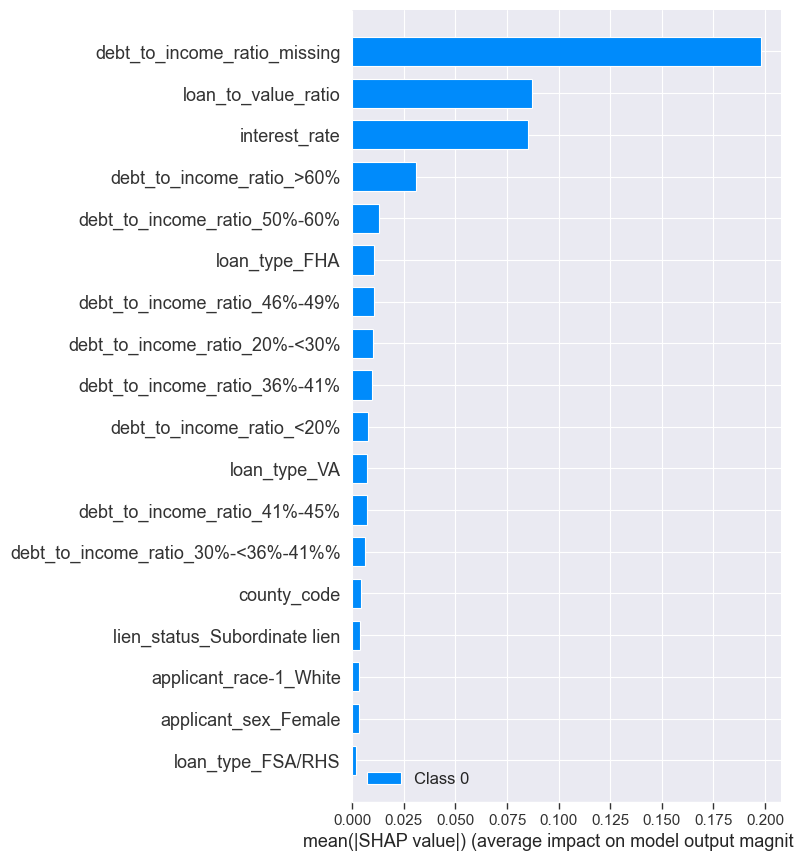

In [66]:
shap.summary_plot(shap_values_rew, X_test_scaled[:150], feature_names=X.columns)

In [67]:
shap.force_plot(explainer_rew.expected_value, shap_values_rew[0], X_test_scaled[:150], feature_names=X.columns)

In [68]:
explainer_rew.expected_value

array([0.57899623])

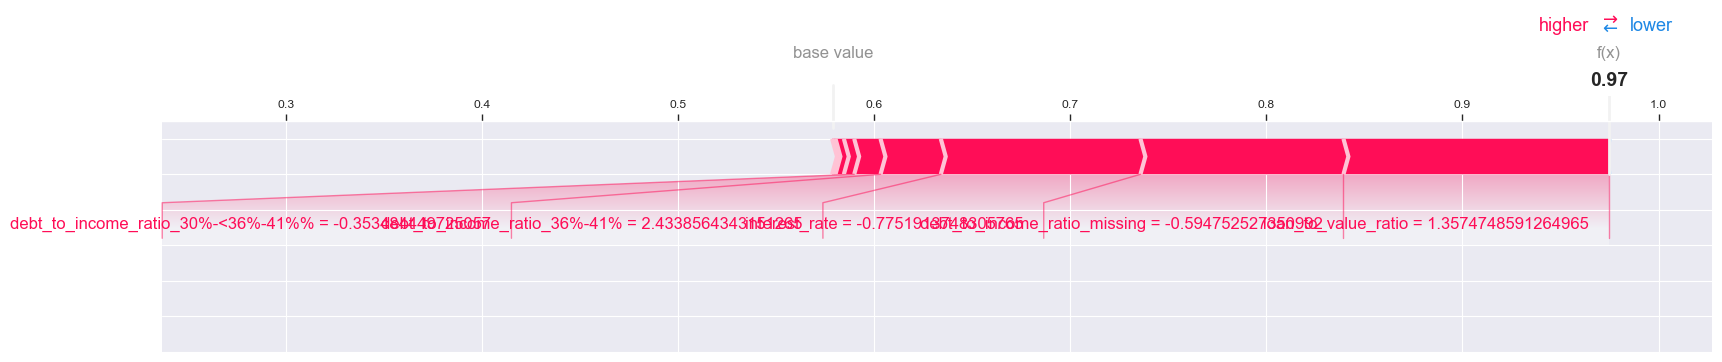

In [69]:
shap.initjs()
shap.force_plot(explainer_rew.expected_value, shap_values_rew[0][0], X_test_scaled[0], feature_names=X.columns, matplotlib=True)

In [70]:
print("Reweighed")
for value in range(10):
    print(str(value) + ": Base value", explainer_rew.expected_value, "Shapley value", shap_values_rew[0][value].sum(), "Sum", shap_values_rew[0][value].sum() + explainer_rew.expected_value)
print("Original")
for value in range(10):
    print(str(value) + ": Base value", explainer.expected_value, "Shapley value", shap_values[0][value].sum(), "Sum", shap_values[0][value].sum() + explainer.expected_value)

Reweighed
0: Base value [0.57899623] Shapley value 0.3957511345203966 Sum [0.97474736]
1: Base value [0.57899623] Shapley value -0.5738188707921654 Sum [0.00517735]
2: Base value [0.57899623] Shapley value 0.3727271715458482 Sum [0.9517234]
3: Base value [0.57899623] Shapley value 0.10620303547941147 Sum [0.68519926]
4: Base value [0.57899623] Shapley value -0.24353523456491533 Sum [0.33546099]
5: Base value [0.57899623] Shapley value -0.5737230139505118 Sum [0.00527321]
6: Base value [0.57899623] Shapley value 0.3791743079479784 Sum [0.95817053]
7: Base value [0.57899623] Shapley value 0.3691246668156236 Sum [0.94812089]
8: Base value [0.57899623] Shapley value 0.3791126767452806 Sum [0.9581089]
9: Base value [0.57899623] Shapley value 0.1247806111630052 Sum [0.70377684]
Original
0: Base value [0.56723671] Shapley value 0.39128608296159656 Sum [0.9585228]
1: Base value [0.56723671] Shapley value -0.5607136521255598 Sum [0.00652306]
2: Base value [0.56723671] Shapley value 0.3977102715

In [71]:
pd.DataFrame(sorted(dict(zip(X.columns, shap_values_rew[0][0])).items(), key=lambda x: x[1], reverse=True))

0         1
0                  loan_to_value_ratio  0.135441
1         debt_to_income_ratio_missing  0.103516
2                        interest_rate  0.101799
3         debt_to_income_ratio_36%-41%  0.030738
4   debt_to_income_ratio_30%-<36%-41%%  0.013419
5         debt_to_income_ratio_50%-60%  0.005278
6         debt_to_income_ratio_46%-49%  0.004264
7            debt_to_income_ratio_>60%  0.001729
8                          county_code  0.000000
9                 applicant_sex_Female  0.000000
10              applicant_race-1_White  0.000000
11                       loan_type_FHA  0.000000
12                        loan_type_VA  0.000000
13                   loan_type_FSA/RHS  0.000000
14       debt_to_income_ratio_20%-<30%  0.000000
15        debt_to_income_ratio_41%-45%  0.000000
16        lien_status_Subordinate lien  0.000000
17           debt_to_income_ratio_<20% -0.000433

In [72]:
shap_diff_race_orig = []
for i in range(15):
    shap_diff_race_orig.append(shap_values[0][i][4])

shap_diff_race_rew = []
for i in range(15):
    shap_diff_race_rew.append(shap_values_rew[0][i][4])

pd.DataFrame({'Original': shap_diff_race_orig, 'Reweighed': shap_diff_race_rew})

Original  Reweighed
0   0.007967   0.000000
1   0.000000   0.000000
2   0.000000   0.000000
3   0.033862   0.000000
4  -0.040735   0.000000
5   0.000000   0.000000
6   0.005740   0.000000
7   0.000000   0.000000
8   0.000000  -0.002664
9   0.000000   0.000000
10 -0.057813  -0.015986
11  0.022925   0.000000
12 -0.115917  -0.016974
13  0.005428   0.000000
14 -0.085322   0.000000

In [73]:
import lime.lime_tabular

In [74]:
lime_exp = lime.lime_tabular.LimeTabularExplainer(X_train_scaled, mode="classification", feature_names=X.columns)

In [75]:
explained_lime = lime_exp.explain_instance(X_test_scaled[0], model.predict, num_features=15, top_labels=1)

157/157 [==============================] - 0s 2ms/step



                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    


In [76]:
explained_lime.show_in_notebook(show_table=True, show_all=False)

In [77]:
# !!!
lime_features_list = ["loan_type_FSA/RHS",
                      "debt_to_income_ratio_>60%",
                      "debt_to_income_ratio_missing",
                      "debt_to_income_ratio_50%-60%",
                      "debt_to_income_ratio_<20%",
                      "interest_rate",
                      "loan_type_FHA",
                      "loan_type_VA",
                      "debt_to_income_ratio_20%-<30%",
                      "lien_status_Subordinate lien",
                      "applicant_sex_Female",
                      "debt_to_income_ratio_46%-49%",
                      "debt_to_income_ratio_36%-41%",
                      "county_code",
                      "debt_to_income_ratio_30%-<36%-41%%"]

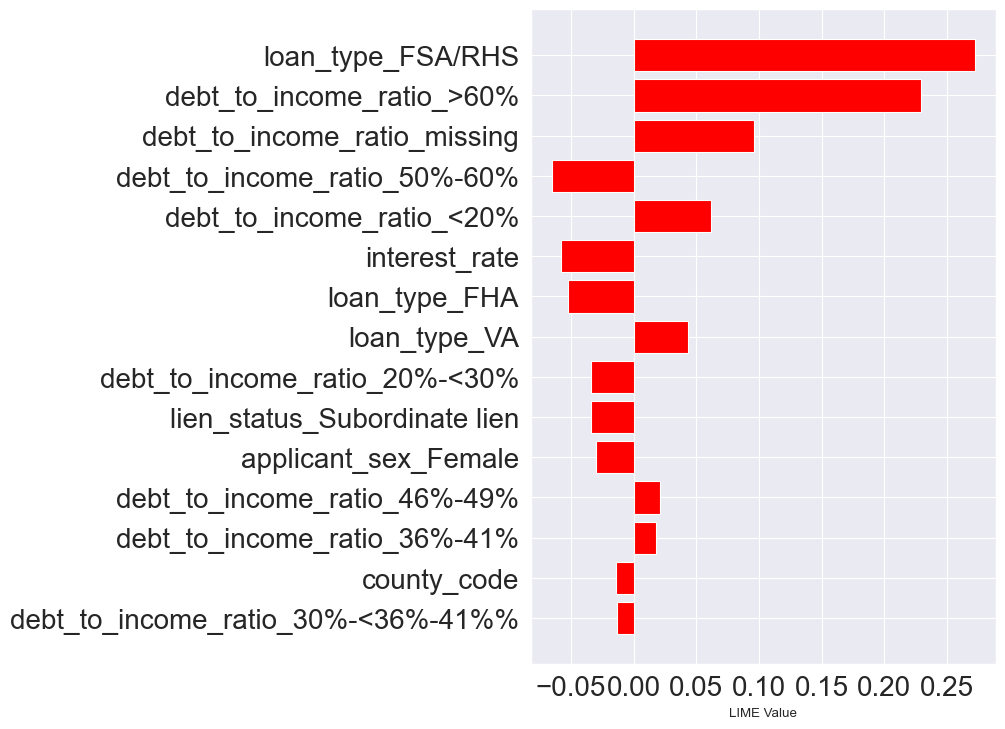

In [78]:
lime_values_list = []

for i in range(15):
    lime_values_list.append(explained_lime.local_exp[0][i][1])

lime_results_df = pd.DataFrame({"Feature Name": lime_features_list, "Value": lime_values_list})

lime_results_df = lime_results_df.reindex(lime_results_df["Value"].abs().sort_values(ascending=True).index)

plt.figure(figsize=(6, 8.5))
plt.barh(lime_results_df["Feature Name"], lime_results_df["Value"], color='red')
plt.xlabel('LIME Value')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

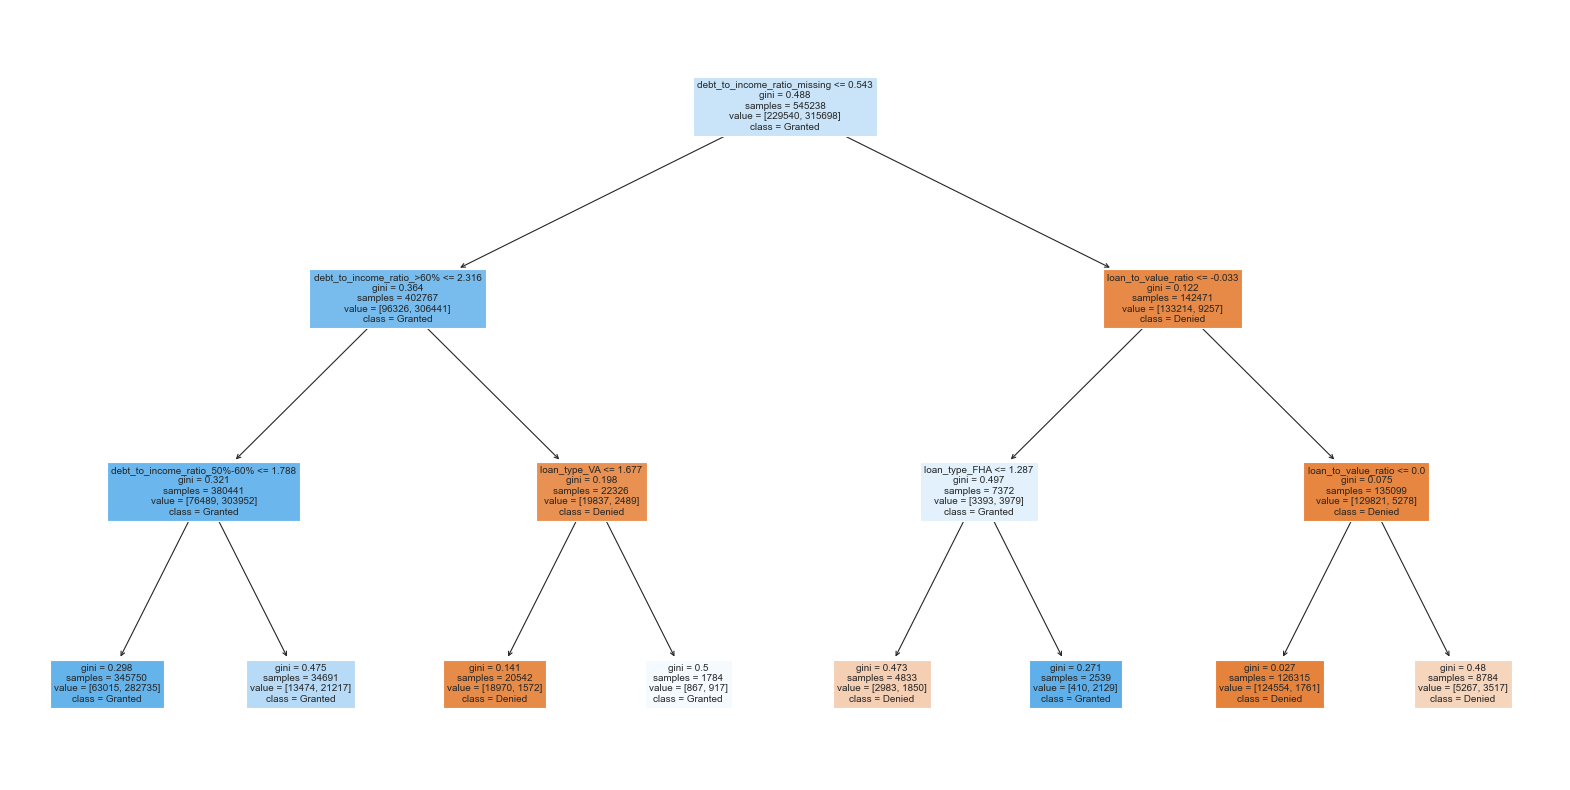

In [79]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import tree

dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train_scaled, y_train)

plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=X.columns, filled=True, class_names=['Denied', 'Granted'])
plt.show()

In [80]:
X_train_original = X_train_scaled
X_val_original = X_val_scaled
X_test_original = X_test_scaled
y_train_original = y_train
y_val_original = y_val

from sklearn.tree import DecisionTreeClassifier
surrogate_model = DecisionTreeClassifier()

surrogate_model.fit(X_train_original, y_train_original)

surrogate_accuracy = surrogate_model.score(X_test_original, y_test)
feature_importance = surrogate_model.feature_importances_

In [81]:
surrogate_accuracy

0.8927037115289809

In [82]:
surrogate_df = X_test.copy()
surrogate_df['prediction'] = surrogate_model.predict(X_test_original)

surrogate_df_white = surrogate_df[mask_white]
surrogate_df_black = surrogate_df[mask_black]

comp_df = comp_df_orig_rew.assign(Surrogate = [accuracy_score(y_test_white, surrogate_df_white['prediction']), 
                                     precision_score(y_test_white, surrogate_df_white['prediction']),
                                     recall_score(y_test_white, surrogate_df_white['prediction']),
                                     f1_score(y_test_white, surrogate_df_white['prediction']),
                                     "NA",
                                     accuracy_score(y_test_black, surrogate_df_black['prediction']),
                                     precision_score(y_test_black, surrogate_df_black['prediction']),
                                     recall_score(y_test_black, surrogate_df_black['prediction']),
                                     f1_score(y_test_black, surrogate_df_black['prediction']),
                                     "NA"])

In [83]:
cm = confusion_matrix(y_test, surrogate_df['prediction'])
print(cm)

[[60371 11277]
 [ 7005 91735]]


In [84]:
comp_df

Original  Reweighted Surrogate
Accuracy White   0.906750    0.905242  0.896127
Precision White  0.886117    0.885774  0.896782
Recall White     0.969923    0.967537  0.935292
F1 Score White   0.926128    0.924852  0.915633
AUC White        0.940839    0.940210        NA
Accuracy Black   0.885835    0.881110  0.874079
Precision Black  0.839948    0.805481  0.845412
Recall Black     0.924391    0.972741  0.883961
F1 Score Black   0.880149    0.881245  0.864257
AUC Black        0.948208    0.948785        NA

In [85]:
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
feature_importance_df

feature  importance
16        debt_to_income_ratio_missing    0.464715
1                        interest_rate    0.154656
2                  loan_to_value_ratio    0.143724
15           debt_to_income_ratio_>60%    0.090883
0                          county_code    0.063538
6                         loan_type_VA    0.016067
5                        loan_type_FHA    0.014178
13        debt_to_income_ratio_50%-60%    0.012217
3                 applicant_sex_Female    0.007984
4               applicant_race-1_White    0.006590
17        lien_status_Subordinate lien    0.006448
14           debt_to_income_ratio_<20%    0.003715
10        debt_to_income_ratio_36%-41%    0.003201
9   debt_to_income_ratio_30%-<36%-41%%    0.002910
8        debt_to_income_ratio_20%-<30%    0.002811
11        debt_to_income_ratio_41%-45%    0.002725
12        debt_to_income_ratio_46%-49%    0.002718
7                    loan_type_FSA/RHS    0.000920

In [86]:
global_surrogate_model = DecisionTreeClassifier()
global_surrogate_model.fit(X_train_original, y_train_original)

global_surrogate_accuracy = global_surrogate_model.score(X_test_original, y_pred)
global_feature_importance = global_surrogate_model.feature_importances_

In [87]:
global_surrogate_accuracy

0.9392680235697349

In [88]:
global_feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': global_feature_importance})
global_feature_importance_df = global_feature_importance_df.sort_values('importance', ascending=False)
global_feature_importance_df

feature  importance
16        debt_to_income_ratio_missing    0.464715
1                        interest_rate    0.154746
2                  loan_to_value_ratio    0.143354
15           debt_to_income_ratio_>60%    0.090883
0                          county_code    0.063721
6                         loan_type_VA    0.016093
5                        loan_type_FHA    0.014220
13        debt_to_income_ratio_50%-60%    0.012217
3                 applicant_sex_Female    0.008106
4               applicant_race-1_White    0.006578
17        lien_status_Subordinate lien    0.006502
14           debt_to_income_ratio_<20%    0.003732
10        debt_to_income_ratio_36%-41%    0.003131
8        debt_to_income_ratio_20%-<30%    0.002882
9   debt_to_income_ratio_30%-<36%-41%%    0.002878
11        debt_to_income_ratio_41%-45%    0.002780
12        debt_to_income_ratio_46%-49%    0.002572
7                    loan_type_FSA/RHS    0.000890

In [89]:
merged_weights_df = pd.merge(global_feature_importance_df, lime_results_df, left_on="feature", right_on = "Feature Name")
merged_weights_df = merged_weights_df.drop(columns="Feature Name")
merged_weights_df.columns = ["Feature", "Global Surrogate Model", "LIME"]
merged_weights_df = merged_weights_df.merge(shap_values_df_mean, left_on = "Feature", right_on = "feature")
merged_weights_df = merged_weights_df.drop(columns="feature")
merged_weights_df.columns = ["Feature", "Global Surrogate Model", "LIME", "SHAP"]
merged_weights_df["LIME"] = merged_weights_df["LIME"].abs()
merged_weights_df = merged_weights_df.sort_values(by="Global Surrogate Model", ascending=False)
merged_weights_df

Feature  Global Surrogate Model      LIME  \
0         debt_to_income_ratio_missing                0.464715  0.096353   
1                        interest_rate                0.154746  0.057934   
2            debt_to_income_ratio_>60%                0.090883  0.229583   
3                          county_code                0.063721  0.014439   
4                         loan_type_VA                0.016093  0.043349   
5                        loan_type_FHA                0.014220  0.052279   
6         debt_to_income_ratio_50%-60%                0.012217  0.065308   
7                 applicant_sex_Female                0.008106  0.030272   
8         lien_status_Subordinate lien                0.006502  0.033965   
9            debt_to_income_ratio_<20%                0.003732  0.061994   
10        debt_to_income_ratio_36%-41%                0.003131  0.017534   
11       debt_to_income_ratio_20%-<30%                0.002882  0.034266   
12  debt_to_income_ratio_30%-<36%-41%%                0.002878  0.013659   
13        debt_to_income_ratio_46%-49%                0.002572  0.020825   
14                   loan_type_FSA/RHS                0.000890  0.271942   

        SHAP  
0   0.218370  
1   0.092245  
2   0.028253  
3   0.007105  
4   0.009214  
5   0.009485  
6   0.013772  
7   0.006134  
8   0.003911  
9   0.007275  
10  0.011973  
11  0.009581  
12  0.008844  
13  0.014326  
14  0.001997

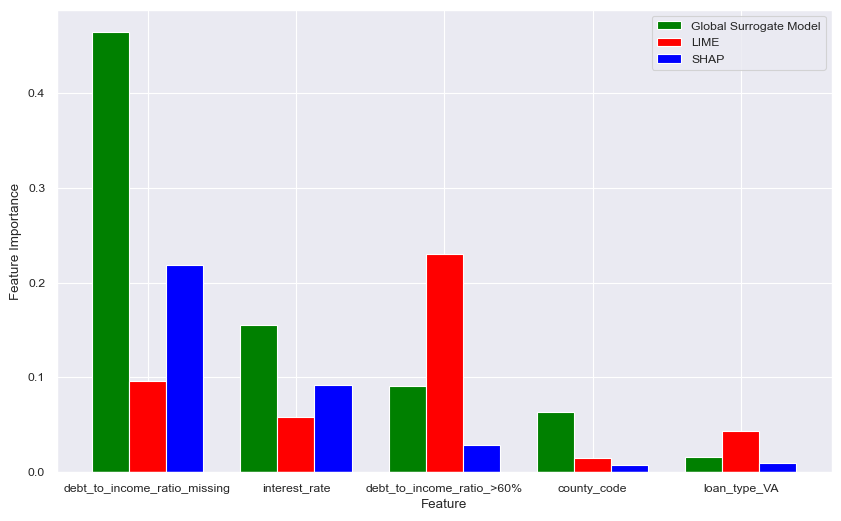

In [90]:
# Sort the DataFrame by the 'Feature' column
# merged_weights_df = merged_weights_df.sort_values('Feature')

# Number of bars (features) to display
num_bars = 5

# Create an array with the positions of each bar
bar_positions = np.arange(num_bars)

# Set the width of each bar
bar_width = 0.25

# Create the figure
plt.figure(figsize=(10, 6))

# Plot the bars for each model, adjusting the position for each one
plt.bar(bar_positions - bar_width, merged_weights_df["Global Surrogate Model"][:num_bars], color='green', label='Global Surrogate Model', width=bar_width)
plt.bar(bar_positions, merged_weights_df["LIME"][:num_bars], color='red', label='LIME', width=bar_width)
plt.bar(bar_positions + bar_width, merged_weights_df["SHAP"][:num_bars], color='blue', label='SHAP', width=bar_width)

# Set the y-ticks to be the feature names
plt.xticks(bar_positions, merged_weights_df["Feature"][:num_bars])

plt.ylabel('Feature Importance')
plt.xlabel('Feature')
plt.legend()
plt.show()

In [91]:
X_train_scaled

array([[-1.44813610e+00,  3.55598300e-01,  1.55154613e+00, ...,
        -2.06628944e-01, -5.94752527e-01, -4.05706796e-01],
       [ 4.43057973e-01, -7.38137853e-05, -5.27438167e-04, ...,
        -2.06628944e-01, -5.94752527e-01, -4.05706796e-01],
       [ 4.39506631e-01, -7.38137853e-05, -5.27438167e-04, ...,
        -2.06628944e-01,  1.68137159e+00,  2.46483423e+00],
       ...,
       [ 5.41033231e-01, -1.39650438e+00, -1.05098414e+00, ...,
        -2.06628944e-01, -5.94752527e-01, -4.05706796e-01],
       [ 4.66037244e-01, -8.78743543e-01, -4.76921098e-01, ...,
        -2.06628944e-01,  1.68137159e+00, -4.05706796e-01],
       [-2.28186586e+00, -7.38137853e-05, -5.27438167e-04, ...,
        -2.06628944e-01,  1.68137159e+00, -4.05706796e-01]])

In [92]:
import lightgbm as lgb

In [93]:
import numpy as np
import pandas as pd
import lightgbm as lgb

X_train_scaled_df = pd.DataFrame(X_train_scaled)

print(X_train_scaled_df.dtypes)

print(np.isnan(X_train_scaled).sum())

S = np.array([1 if i == 0 else 0 for i in X_train['applicant_race-1_White']])

print(len(S), len(X_train_scaled))

train_data = lgb.Dataset(X_train_scaled, label=y_train)

constraint = lgb.Dataset(X_train_scaled, label=y_train, group=S)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "n_estimators": 200,
    "learning_rate": 0.1,
    "max_depth": 3,
    "min_data_in_leaf": 2,
    "feature_fraction": 1.0,
    "random_state": 42,
    "verbose": -1  
}

try:
    fairgbm_mod = lgb.train(params, train_data, valid_sets=[constraint])
    y_pred_fairgbm = fairgbm_mod.predict(X_test_scaled)
except Exception as e: 
    print("Error:", e)


0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
13    float64
14    float64
15    float64
16    float64
17    float64
dtype: object
0
545238 545238


Found `n_estimators` in params. Will use it instead of argument


Error: Sum of query counts (545238) differs from the length of #data (84175)


In [94]:
print("Length of X_train_scaled:", len(X_train_scaled))
print("Length of S:", len(S))


Length of X_train_scaled: 545238
Length of S: 545238


### CIU Test

In [95]:
# import ciu

In [112]:
# X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)
# X_test_df

county_code  interest_rate  loan_to_value_ratio  applicant_sex_Female  \
238575     0.448072      -0.775191             1.357475             -0.729559   
328268     0.538735      -0.000074            -0.000527             -0.729559   
594872    -2.283119       2.724872            -2.981821             -0.729559   
635106     0.479407      -0.000074            -0.000527             -0.729559   
451212    -2.281657      -3.778204            -2.048937              1.370691   
...             ...            ...                  ...                   ...   
541849    -1.448136      -0.713060            -0.323055             -0.729559   
472508     0.481914       1.399404             0.720483             -0.729559   
728610     0.538735       0.260330            -1.308307             -0.729559   
485022     0.538735      -0.050326            -0.607200              1.370691   
843594    -1.448136      -0.000074            -0.000527              1.370691   

        applicant_race-1_White  loan_type_FHA  loan_type_VA  \
238575                0.427279      -0.342862     -0.275507   
328268                0.427279      -0.342862     -0.275507   
594872                0.427279      -0.342862     -0.275507   
635106                0.427279      -0.342862     -0.275507   
451212               -2.340392      -0.342862     -0.275507   
...                        ...            ...           ...   
541849                0.427279      -0.342862     -0.275507   
472508                0.427279      -0.342862     -0.275507   
728610                0.427279      -0.342862     -0.275507   
485022                0.427279      -0.342862     -0.275507   
843594                0.427279      -0.342862     -0.275507   

        loan_type_FSA/RHS  debt_to_income_ratio_20%-<30%  \
238575          -0.092947                      -0.361040   
328268          -0.092947                      -0.361040   
594872          -0.092947                      -0.361040   
635106          -0.092947                      -0.361040   
451212          -0.092947                      -0.361040   
...                   ...                            ...   
541849          -0.092947                      -0.361040   
472508          -0.092947                      -0.361040   
728610          -0.092947                       2.769772   
485022          -0.092947                      -0.361040   
843594          -0.092947                      -0.361040   

        debt_to_income_ratio_30%-<36%-41%%  debt_to_income_ratio_36%-41%  \
238575                           -0.353484                      2.433856   
328268                           -0.353484                     -0.410871   
594872                           -0.353484                      2.433856   
635106                           -0.353484                     -0.410871   
451212                           -0.353484                     -0.410871   
...                                    ...                           ...   
541849                           -0.353484                     -0.410871   
472508                           -0.353484                     -0.410871   
728610                           -0.353484                     -0.410871   
485022                           -0.353484                     -0.410871   
843594                           -0.353484                     -0.410871   

        debt_to_income_ratio_41%-45%  debt_to_income_ratio_46%-49%  \
238575                     -0.348057                     -0.303503   
328268                     -0.348057                     -0.303503   
594872                     -0.348057                     -0.303503   
635106                     -0.348057                     -0.303503   
451212                     -0.348057                     -0.303503   
...                              ...                           ...   
541849                     -0.348057                      3.294859   
472508                      2.873092                     -0.303503   
728610        

In [114]:
'''inst_ind = 42
instance = X_test_df.iloc[inst_ind]
inst_class = y_test.iloc[inst_ind]
pred = y_pred[inst_ind].astype(int)
print("Model prediction:", pred[0], "True label:", inst_class)'''

Model prediction: 0 True label: 0


In [122]:
# print(instance.shape, inst_class.shape)

(18,) ()


In [115]:
# ciu_model = ciu.CIU(model.predict, HMDA_clean_final["loan_granted"].astype("category").cat.categories.tolist(), X_train)

In [123]:
# CIUres = ciu_model.explain(instance)

InvalidArgumentError: Graph execution error:

Detected at node 'sequential/dense/MatMul' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 604, in run_forever
      self._run_once()
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Hauke\AppData\Local\Temp\ipykernel_84048\4067694405.py", line 1, in <module>
      CIUres = ciu_model.explain(instance)
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\ciu\CIU.py", line 244, in explain
      ciu = self.explain_core([i], instance, output_inds=output_inds, nsamples=nsamples, neutralCU=neutralCU,
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\ciu\CIU.py", line 144, in explain_core
      outvals = self.predictor(self.instance)
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2111, in predict_step
      return self(x, training=False)
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\layers\core\dense.py", line 241, in call
      outputs = tf.matmul(a=inputs, b=self.kernel)
Node: 'sequential/dense/MatMul'
Matrix size-incompatible: In[0]: [18,1], In[1]: [18,32]
	 [[{{node sequential/dense/MatMul}}]] [Op:__inference_predict_function_4788111]